In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

In [2]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [84]:
columns = data.columns

In [3]:
data.head(5)

,Timestamp,ARO,SATUR_PRESSURE,BOIL_PERCENT,OCTANE_NUMBER,percent_01_LAB,percent_04_LAB,quality_01_LAB,pressure_01_LAB,consumption_09,...,temperature_08,temperature_14,temperature_01_LAB,temperature_21,temperature_22,temperature_23,temperature_24,consumption_01,pressure_11,temperature_20
0,01.01.2016 00:00:00,65.59,48.0,6.0,98.9,6.87640,64.05901,98.45841,56.06648,0.00292,...,134.7649,25.61035,90.86990,-3.72980,-7.13281,-1.0,11.86261,59.14596,70.77777,519.1353
1,01.01.2016 00:01:00,65.59,48.0,6.0,98.9,6.86923,64.01093,98.45134,56.04396,0.00292,...,134.8389,25.61035,90.90942,-3.72989,-7.13306,-1.0,11.86295,59.18106,70.93322,519.1353
2,01.01.2016 00:02:00,65.59,48.0,6.0,98.9,6.86095,63.99218,98.44153,56.01728,0.00292,...,134.6192,25.61055,90.88013,-3.73050,-7.13440,-1.0,11.86490,59.16980,70.03181,519.1346
3,01.01.2016 00:03:00,65.59,48.0,6.0,98.9,6.85725,63.98800,98.44115,56.01207,0.00292,...,134.6191,25.63477,90.87057,-3.73145,-7.13660,-1.0,11.86804,59.30387,70.46443,519.1337
4,01.01.2016 00:04:00,65.59,48.0,6.0,98.9,6.85561,63.98110,98.43896,56.00104,0.00292,...,134.6191,25.63477,90.90518,-3.73212,-7.13818,-1.0,11.87030,59.26101,69.81942,519.1330


In [4]:
def preprocess(df, K=5):
    df = df.groupby(df.index //5).mean() #усреднение
    df_np = df.to_numpy()
    df_np = df_np[1:len(df_np), ...] - df_np[0:-1, ...] #дифференцирование
    df_np = (df_np - df_np.mean()) / df_np.std() #масштабирование
    df = pd.DataFrame(df_np, columns=df.columns)
    return df

In [5]:
#усреднение данных за 5 минут, дискретное дифференцирование, масштабирование
preprocess(data).to_csv("DataSet_preprocessed.csv")

In [6]:
preprocessed_data = pd.read_csv("DataSet_preprocessed.csv")

In [70]:
preprocessed_data.shape

(408095, 68)

In [71]:
def create_lag(data, size_of_lag=1):
    """
    data (N, Q)
    return lag (N, size_of_lag, Q)
    """
    data = data.to_numpy()
    print(data.shape)
    result = np.zeros((data.shape[0], size_of_lag, data.shape[1])) #(N, SL, Q)
    for i in range(size_of_lag): 
        result[:, i, :] = np.roll(data, -i, axis=0)
    return result[size_of_lag:data.shape[0] - size_of_lag, ...]

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2022-10-20 16:50:01.746795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 16:50:01.746814: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [72]:

def split_to_train_and_test(dataset, percent_of_test=20):
    K = 5
    values = create_lag(dataset, K)
    n_split = int((1 - percent_of_test/ 100) * dataset.shape[0])
    print(f"{n_split=}")
    train = values[:n_split, ...]
    test = values[n_split:, ...]
    train_X, train_y = train[:-1, ...], train[1:, 0, ...]
    test_X, test_y = test[:-1, ...], test[1:, 0, ...]
    train_X = np.transpose(train_X, axes=(0, 2, 1))
    test_X = np.transpose(test_X, axes=(0, 2, 1))
    print(f"{train_X.shape=}, {train_y.shape=}, {test_X.shape=}, {test_y.shape=}")
    return train_X, train_y, test_X, test_y

In [77]:
def learn(train_X, train_y, test_X, test_y):
    model = Sequential()
    #batch_size, (time_steps, units)
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=10, batch_size=72, shuffle=False, validation_data=(test_X, test_y), verbose=2)
    return model, history

quality >= 90 :
L = 431204;  R = 2040480; len = 1609276

Частично данные из DataSet2

In [78]:
partial_data = preprocessed_data.iloc[431205 // 5:531205 // 5, 1:]
partial_data.shape

(20000, 67)

In [79]:
train_X, train_y, test_X, test_y = split_to_train_and_test(partial_data)

(20000, 67)
n_split=16000
train_X.shape=(15999, 67, 5), train_y.shape=(15999, 67), test_X.shape=(3989, 67, 5), test_y.shape=(3989, 67)


In [80]:
model, history = learn(train_X, train_y, test_X, test_y)

Epoch 1/10
223/223 - 6s - loss: 0.1341 - val_loss: 0.0157 - 6s/epoch - 26ms/step
Epoch 2/10
223/223 - 5s - loss: 0.0770 - val_loss: 0.0113 - 5s/epoch - 21ms/step
Epoch 3/10
223/223 - 5s - loss: 0.0735 - val_loss: 0.0098 - 5s/epoch - 21ms/step
Epoch 4/10
223/223 - 5s - loss: 0.0716 - val_loss: 0.0111 - 5s/epoch - 21ms/step
Epoch 5/10
223/223 - 5s - loss: 0.0704 - val_loss: 0.0085 - 5s/epoch - 21ms/step
Epoch 6/10
223/223 - 5s - loss: 0.0696 - val_loss: 0.0059 - 5s/epoch - 21ms/step
Epoch 7/10
223/223 - 5s - loss: 0.0692 - val_loss: 0.0093 - 5s/epoch - 20ms/step
Epoch 8/10
223/223 - 5s - loss: 0.0676 - val_loss: 0.0095 - 5s/epoch - 21ms/step
Epoch 9/10
223/223 - 5s - loss: 0.0668 - val_loss: 0.0089 - 5s/epoch - 21ms/step
Epoch 10/10
223/223 - 5s - loss: 0.0662 - val_loss: 0.0063 - 5s/epoch - 21ms/step


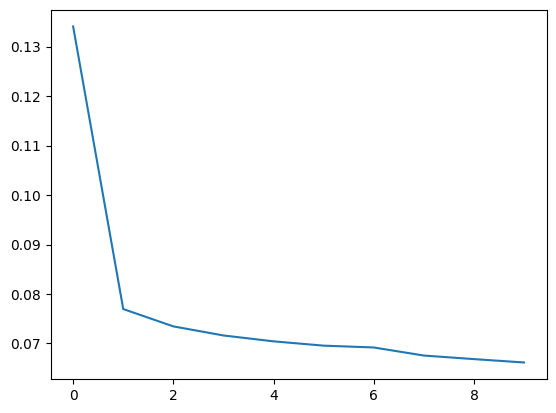

In [81]:
plt.plot(history.history['loss'], label='train')


In [82]:
predicted = model.predict(test_X)
print(predicted.shape)

125/125 [==============================] - 1s 5ms/step
(3989, 67, 1)


In [86]:
predicted_values = predicted[:100, ...]
print(f"{predicted_values.shape=}")

for i in range(predicted_values.shape[1]):
    plt.plot(predicted_values[:, i, 0], color="red", label="prediction")
    plt.plot(test_y[:100, i], color="green", label="origin")
    plt.xlabel("Time")
    plt.ylabel(str(columns[i + 1]))
    plt.legend()
    plt.savefig("../plots/partionDataSet2/" + str(i) + " " + str(columns[i + 1]) + '.png')
    # plt.show()
    plt.clf()

predicted_values.shape=(100, 67, 1)


<Figure size 640x480 with 0 Axes>

Данные https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


In [ ]:
dataset = pd.read_csv('../../materials/pollution.csv')
# dataset.drop(columns=["date"], inplace=True)
print(dataset.head(5))
dataset.to_csv('../../materials/pollution.csv', index=False)

   pollution  dew  temp   press  wnd_spd  snow  rain
0      129.0  -16  -4.0  1020.0     1.79     0     0
1      148.0  -15  -4.0  1020.0     2.68     0     0
2      159.0  -11  -5.0  1021.0     3.57     0     0
3      181.0   -7  -5.0  1022.0     5.36     1     0
4      138.0   -7  -5.0  1022.0     6.25     2     0


In [ ]:
dataset = pd.read_csv('../../materials/pollution.csv')


In [ ]:
train_X, train_y, test_X, test_y = split_to_train_and_test(dataset)


(43800, 7)
n_split=8760
train_X.shape=(8759, 7, 5), train_y.shape=(8759, 7), test_X.shape=(35029, 7, 5), test_y.shape=(35029, 7)


In [ ]:
model, history = learn(train_X, train_y, test_X, test_y)

Epoch 1/10
122/122 - 2s - loss: 164.9444 - val_loss: 162.1135 - 2s/epoch - 17ms/step
Epoch 2/10
122/122 - 1s - loss: 162.1142 - val_loss: 159.9199 - 856ms/epoch - 7ms/step
Epoch 3/10
122/122 - 1s - loss: 160.1134 - val_loss: 157.9131 - 864ms/epoch - 7ms/step
Epoch 4/10
122/122 - 1s - loss: 158.1695 - val_loss: 156.2818 - 886ms/epoch - 7ms/step
Epoch 5/10
122/122 - 1s - loss: 156.5624 - val_loss: 154.7734 - 903ms/epoch - 7ms/step
Epoch 6/10
122/122 - 1s - loss: 155.1566 - val_loss: 153.5772 - 899ms/epoch - 7ms/step
Epoch 7/10
122/122 - 1s - loss: 153.9722 - val_loss: 152.4633 - 937ms/epoch - 8ms/step
Epoch 8/10
122/122 - 1s - loss: 152.8335 - val_loss: 151.3686 - 851ms/epoch - 7ms/step
Epoch 9/10
122/122 - 1s - loss: 151.7324 - val_loss: 150.3547 - 849ms/epoch - 7ms/step
Epoch 10/10
122/122 - 1s - loss: 150.7250 - val_loss: 149.3523 - 844ms/epoch - 7ms/step


In [ ]:
predicted_values = model.predict(test_X)
print(predicted.shape)

1095/1095 [==============================] - 1s 854us/step
(35029, 7, 1)


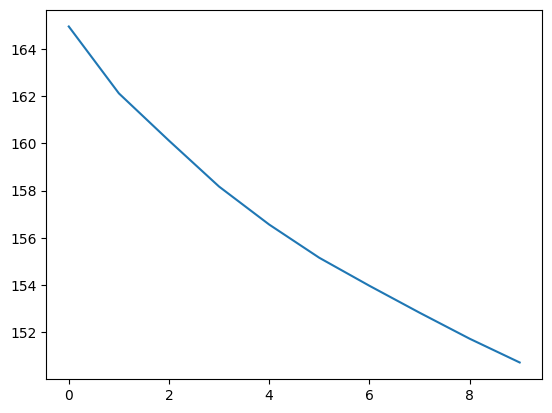

In [78]:
plt.plot(history.history['loss'], label='train')


In [88]:

predicted_values = predicted_values[100:200, ...]
print(f"{predicted_values.shape=}")

for i in range(predicted_values.shape[1]):
    plt.plot(predicted_values[:, i, 0], color="red", label="prediction")
    # plt.plot(test_y[100:200, i], color="green", label="origin")
    plt.savefig("../plots/smallDataSet/" + str(i) + '.png')
    plt.xlabel("Time")
    plt.ylabel(str(columns[i + 1]))
    plt.legend()
    # plt.show()
    plt.clf()

predicted_values.shape=(0, 67, 1)


<Figure size 640x480 with 0 Axes>